In [3]:
import os
BAR = 'Barcodes_1d'
ROOT = open('../root').read().strip()
print ROOT
img_path = os.path.join(ROOT, 'common')
print img_path
anno_path = os.path.join(ROOT, BAR, 'annotations.json')
print anno_path
empty_path = os.path.join(ROOT, 'Empty', 'annotations.json')
print empty_path

/home/nik-kochetov/work
/home/nik-kochetov/work/common
/home/nik-kochetov/work/Barcodes_1d/annotations.json
/home/nik-kochetov/work/Empty/annotations.json


In [4]:
import converter
from model import SSDModel, PixelsModel
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
%matplotlib inline

Using TensorFlow backend.


In [5]:
model = PixelsModel()

In [6]:
path = os.path.join(ROOT, 'pixel_models', 'model.18-03-2018.gen3.8_pixels_concat_more_context.ssd.06.hdf5')
model.model.load_weights(path)

In [7]:
import json
with open(anno_path) as f:
    annos = json.loads(f.read())
print len(annos)
print annos[0]

with open(empty_path) as f:
    empty_annos = json.loads(f.read())
print len(empty_annos)
print empty_annos[0]

all_annos = annos + empty_annos

8111
{u'name': u'0001.jpg', u'shape': [3585, 2661, 3], u'Rects': [[594, 1081, 326, 575], [568, 1054, 1131, 1382], [593, 1074, 718, 968], [572, 1057, 1566, 1817], [564, 1050, 1964, 2217], [567, 1048, 2437, 2691]], u'path': u'Barcodes_1d/UPC-E', u'id': u'0001', u'Types': [u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE']}
10156
{u'Rects': [], u'path': u'Empty', u'shape': [4400, 3400, 3], u'name': u'9468_020.4B.tif.jpg', u'Types': []}


In [6]:
anno = annos[10]
curr_img_path = os.path.join(ROOT, anno['path'], anno['name'])
print curr_img_path

/home/nik-kochetov/work/Barcodes_1d/Code 93/0008.jpg


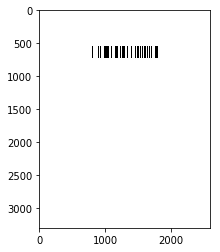

In [7]:
img = np.asarray(Image.open(curr_img_path))
imshow(img)

In [8]:
img.shape

(3300, 2592, 3)

In [9]:
factor = 4
shape = tuple(map(lambda x: x / factor, img.shape[:2]))
print shape

(825, 648)


In [10]:
img_2 = image.load_img(curr_img_path, target_size=shape)
img_2 = image.img_to_array(img_2)
img_2 = img_2.reshape([1] + list(img_2.shape))
img_2 = preprocess_input(img_2)
print img_2.shape

(1, 825, 648, 3)


In [11]:
tensor = model.model.predict(img_2) #img.reshape([1]  + list(img.shape)))

In [12]:
print tensor.shape

(1, 825, 648, 2)


In [13]:
print np.sort(tensor[:,:,:,1][np.nonzero(tensor[:,:,:,1])])

[-9.97652149 -9.8207674  -9.70193195 ...,  1.10449564  1.23331571
  1.31790876]


In [14]:
conf = tensor[0]
print np.mean(conf), np.var(conf)
probs = 1.0 / (1.0 + np.exp(-conf[:,:,0]))# np.exp(conf[:,:,1]) / (np.exp(conf[:,:,0]) + np.exp(conf[:,:,1]))
print np.mean(probs), np.var(probs), np.min(probs), np.max(probs)

-7.00915 0.541943
0.00312787 0.000496041 5.74767e-05 0.822382


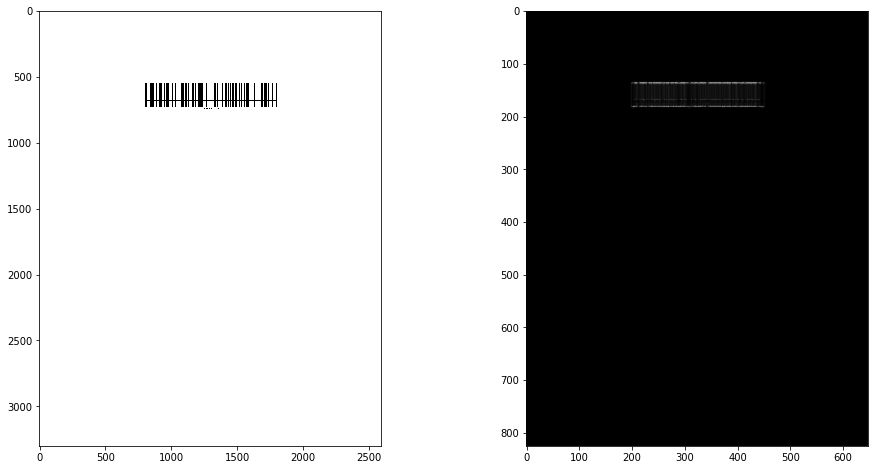

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img)
ax2.imshow(probs, cmap='gray', vmin = np.min(probs), vmax = np.max(probs))

In [16]:
import generator
reload(generator)
from generator import Generator
ssd_generator = Generator(ROOT, model)

In [17]:
generator = ssd_generator.generate_pixels(annos, 64, True)

In [25]:
gen = next(generator)

next batch:
img: Barcodes_1d/Interleaved 2 of 5 (2)/0367.jpg
window:  Rect(219, 2396, 1243, 3420)


In [26]:
print gen[0].shape
print gen[1].shape

(1, 512, 512, 3)
(1, 512, 512, 2)


In [27]:
img = gen[0][0]
conf = gen[1][0]
probs = 1.0 / (1.0 + np.exp(-conf[:,:,0])) # np.exp(conf[:,:,1]) / (np.exp(conf[:,:,0]) + np.exp(conf[:,:,1]))
print np.mean(probs), np.var(probs), np.min(probs), np.max(probs)

0.514277217318 0.00309503460597 0.5 0.73105857863


255.0 0.0


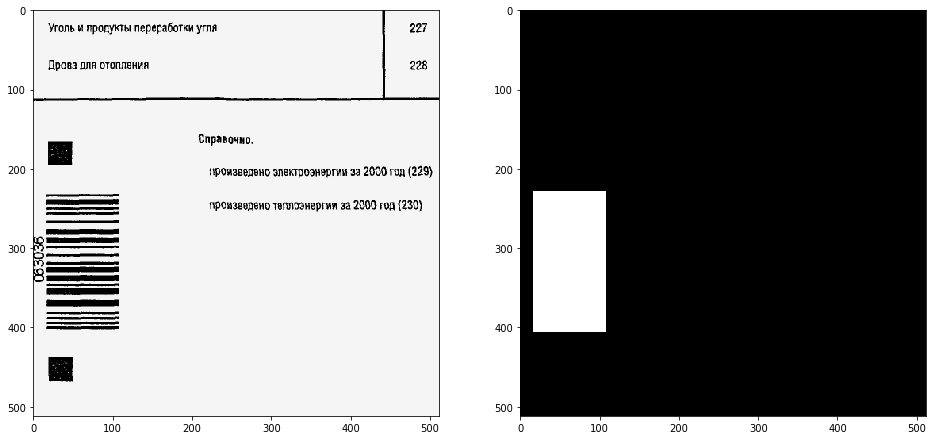

In [28]:
def show_img_from_gen(ax, img):
    def unprocess(y):
            x = np.copy(y)
            # Zero-decenter by mean pixel
            x[:, :, :, 0] += 103.939
            x[:, :, :, 1] += 116.779
            x[:, :, :, 2] += 123.68

            # 'BGR'->'RGB'
            x = x[:, :, :, ::-1]
            print np.max(x), np.min(x)
            return x / 265.0


    ax.imshow(np.reshape(unprocess(img)[0], img.shape[1:]))
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img_from_gen(ax1, gen[0])
ax2.imshow(probs, cmap='gray', vmin = np.min(probs), vmax = np.max(probs))

In [29]:
tensor = model.model.predict(gen[0])

In [30]:
conf = tensor[0]
print np.mean(conf), np.var(conf)
probs = 1.0 / (1.0 + np.exp(-conf[:,:,0])) # np.exp(conf[:,:,1]) / (np.exp(conf[:,:,0]) + np.exp(conf[:,:,1]))
print np.mean(probs), np.var(probs), np.min(probs), np.max(probs)

-6.62913 1.6737
0.00733832 0.000857318 2.05504e-05 0.700911


255.0 0.0


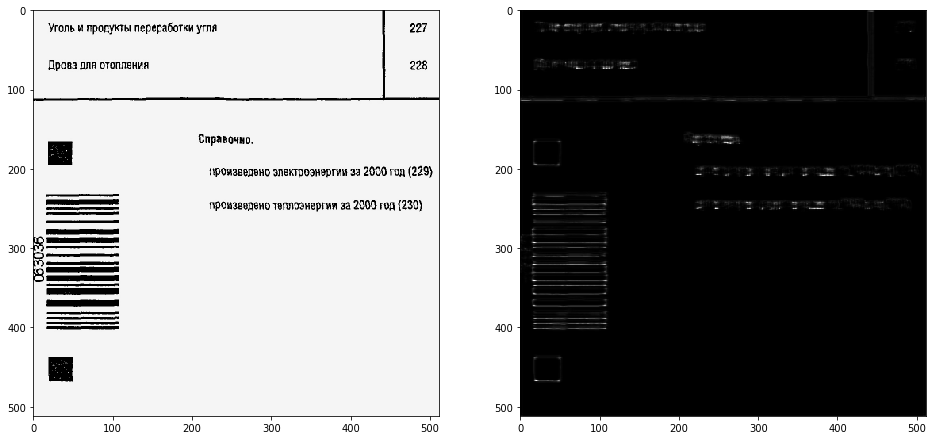

In [31]:
def show_img_from_gen(ax, img):
    def unprocess(y):
            x = np.copy(y)
            # Zero-decenter by mean pixel
            x[:, :, :, 0] += 103.939
            x[:, :, :, 1] += 116.779
            x[:, :, :, 2] += 123.68

            # 'BGR'->'RGB'
            x = x[:, :, :, ::-1]
            print np.max(x), np.min(x)
            return x / 265.0


    ax.imshow(np.reshape(unprocess(img)[0], img.shape[1:]))
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img_from_gen(ax1, gen[0])
ax2.imshow(probs, cmap='gray', vmin = np.min(probs), vmax = np.max(probs))